In [1]:
import mlflow
import torch
import os
# os.environ["TORCH_CPP_LOG_LEVEL"]="INFO"
# os.environ["TORCH_DISTRIBUTED_DEBUG"] = "DETAIL"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, IterableDataset, DataLoader, RandomSampler
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
import numpy.random as npr
from glob import glob
from torch_ema import ExponentialMovingAverage
# from pytorch_optimizer import SOAP

import sys
import re

# # non-interactive
# prog_bar = False
# interactive
sys.argv[1] = "1" # set this to 1 so that if notebook is converted to script, it can actually be used
sys.argv[2] = "0" # set this to 0 so that if notebook is converted to script, it can actually be used
prog_bar = True

argv1 = int(sys.argv[1])
argv2 = int(sys.argv[2])

# SEED = argv1
SEED = npr.randint(100)#29#234834#8483#
torch.manual_seed(SEED)
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"#"cuda:2"

# DEVICE = "cuda"

In [3]:
NUM_VAL=4000

def setup_mlflow_tracking(experiment_name, run_name, params, uri="http://127.0.0.1:5000"):
    mlflow.end_run()
    mlflow.set_tracking_uri(uri)
    mlflow.set_experiment(experiment_name)
    mlflow.pytorch.autolog(log_models=False, log_datasets=False, checkpoint=False)
    mlflow.start_run(run_name=run_name)
    for k,v in params.items():
        mlflow.log_param(str(k), str(v))

NUM_EPOCHS = 200
# BATCH_SIZE = 512 # 1000 #1024
LEARNING_RATE = 1e-3
ERR = 1e-6
NLEV = 42
NLEV_ORIG = 60
# # "engression"
# if argv1 == 0:
#     NOISE_LVL = 0.5
# elif argv1 == 1:
#     NOISE_LVL = 0.75
# elif argv1 == 2:
#     NOISE_LVL = 1
# elif argv1 == 3:
#     NOISE_LVL = 2

def r2_score(y_pred:torch.Tensor, y_true:torch.Tensor) -> float:
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    
    r2 = 1 - ss_res / ss_tot
    
    return r2.item()

In [4]:
# BATCH_SIZE = 384*6*3
BATCH_SIZE = 256 #1000 #512 #1000
SCHEDULER_PATIENCE = 6
SCHEDULER_FACTOR = 10**(-0.2)

In [5]:
n_column_features = 18#15
n_scalar_features = 1#14#16#4
n_features = n_column_features*NLEV+n_scalar_features
print(n_features)

757


In [6]:
n_column_targets = 6#6
n_scalar_targets = 2#8
n_targets = n_column_targets*NLEV+n_scalar_targets
print(n_targets)

254


In [7]:
# notpfull_mask = np.ones(916, dtype=bool)
# notpfull_mask[840:900] = False

# n_column_features = 14
# n_features = n_column_features*NLEV+n_scalar_features

In [8]:
class DaskDataset(Dataset):
    def __init__(self, x, y):
        """
        Initialize with NumPy arrays.
        """
        assert x.shape[0] == y.shape[0], "Features and labels must have the same number of samples"
        
        new_xshape0 = x.shape[0] - x.shape[0]%BATCH_SIZE
        x = x[:new_xshape0,:-2].reshape(new_xshape0//BATCH_SIZE, BATCH_SIZE, x.shape[1])
        x = x.rechunk((1, BATCH_SIZE, x.shape[1]))

        new_yshape0 = y.shape[0] - y.shape[0]%BATCH_SIZE
        y = y[:new_yshape0,:].reshape(new_yshape0//BATCH_SIZE, BATCH_SIZE, y.shape[1])
        y = y.rechunk((1, BATCH_SIZE, y.shape[1]))
        self.x = x
        self.y = y

    def __len__(self):
        """
        Total number of samples.
        """
        return self.x.shape[0]
    

    def __getitem__(self, index):
        """
        Generate one sample of data.
        """
        # chunk_start = index * self.x.chunks[0][0]
        # chunk_end = chunk_start + self.x.chunks[0][0]
        # x = torch.from_numpy(self.x[chunk_start:chunk_end].compute()).float()
        # y = torch.from_numpy(self.y[chunk_start:chunk_end].compute()).float()
        x = torch.from_numpy(self.x[index].compute()).float()
        y = torch.from_numpy(self.y[index].compute()).float()
        # y = torch.tensor(self.y[index]).float()#.to(DEVICE)
        x = torch.cat(
            [
                x[:,:n_column_features*NLEV].reshape(BATCH_SIZE, n_column_features, NLEV).permute(0, 2, 1),
                x[:,n_column_features*NLEV:].unsqueeze(1).repeat(1, NLEV, 1).view(BATCH_SIZE, NLEV, n_scalar_features),
            ],
            -1,
        )
        # x[:,:n_column_features*NLEV].reshape(BATCH_SIZE, n_column_features, NLEV).permute(0, 2, 1)
        
        x = x.to(torch.float32)
        y = y.to(torch.float32)
        return x, y

In [9]:
# To ablate all 2d variables except pressure (t0,t-1) and clat,slat
only_ps_lat_2d_mask = np.ones(1096, dtype=bool)
only_ps_lat_2d_mask[1081:1090] = False
only_ps_lat_2d_mask[1091:1094] = False
no_lat_mask = np.ones(1096, dtype=bool)
no_lat_mask[1094:1096] = False
only_ps_lat_2d_mask[1081:1090] = False
only_3d_mask = np.ones(1096, dtype=bool)
only_3d_mask[1080:] = False
no_ps_tm1_mask = np.ones(1096, dtype=bool)
no_ps_tm1_mask[1091] = False
only_ps_mask = np.ones(1096, dtype=bool)
only_ps_mask[1081:] = False
vertical_inmask = np.ones(1096, dtype=bool)
vertical_outmask = np.ones(362, dtype=bool)
for i in range(n_column_features):
    vertical_inmask[i*NLEV_ORIG:i*NLEV_ORIG+NLEV_ORIG-NLEV] = False
for i in range(n_column_targets):
    vertical_outmask[i*NLEV_ORIG:i*NLEV_ORIG+NLEV_ORIG-NLEV] = False

combined_in_mask = (vertical_inmask & only_ps_mask)
# combined_in_mask = (vertical_inmask & no_lat_mask & no_ps_tm1_mask)
# combined_in_mask = (vertical_inmask & no_ps_tm1_mask)

In [10]:
class NumpyDataset(Dataset):
    def __init__(self, x, y, std=0, mask=None):
        """
        Initialize with NumPy arrays.
        """
        assert x.shape[0] == y.shape[0], "Features and labels must have the same number of samples"
        self.x = x
        self.y = y
        self.mask = mask
        self.std = std
        if self.mask is not None:
            print('Attention: Using mask for inputs')

    def __len__(self):
        """
        Total number of samples.
        """
        return self.x.shape[0]
    

    def __getitem__(self, index):
        """
        Generate one sample of data.
        """
        # Convert the data to tensors when requested
        x = torch.from_numpy(self.x[index]).float()#.to(DEVICE)

        # Add noise to inputs
        # Generate Gaussian noise with mean=0 and std=sqrt(variance)
        if self.std > 0:
            noise = torch.randn_like(x) * self.std
            x = x * (1 + noise)
        
        # x = torch.tensor(self.x[index]).float()#.to(DEVICE)
        if self.mask is not None:
            x = x[~self.mask]
        y = torch.from_numpy(self.y[index]).float()#.to(DEVICE)
        # y = torch.tensor(self.y[index]).float()#.to(DEVICE)
        
        x = torch.cat(
            [
                x[:n_column_features*NLEV].reshape(n_column_features, NLEV).permute(1, 0),
                x[n_column_features*NLEV:].unsqueeze(1).repeat(NLEV, 1).view(NLEV, n_scalar_features),
            ],
            -1,
        )
        # x[:n_column_features*NLEV].reshape(n_column_features, NLEV).permute(1, 0)
        
        x = x.to(torch.float32)
        y = y.to(torch.float32)
        return x, y

# x_train_cs = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_qcqi/train/train_input_normed_25Msample.npy')
x_train_cs = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_qcqi/train/train_input_normed_10ksample.npy')
# x_train_cs = x_train_cs[:,:-2]
# x_train_cs = x_train_cs[:,only_ps_lat_2d_mask]
# x_train_cs = x_train_cs[:,(vertical_inmask & only_3d_mask)]
x_train_cs = x_train_cs[:,combined_in_mask]
# x_train_cs = x_train_cs[:,vertical_inmask]
# x_train_cs = x_train_cs[:,notpfull_mask]
# y_train_cs = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_qcqi/train/train_target_normed_25Msample.npy')
y_train_cs = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_qcqi/train/train_target_normed_10ksample.npy')
y_train_cs = y_train_cs[:,vertical_outmask]

# For testing
# x_val_cs = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_qcqi/test/test_input_normed_5Msample.npy')
x_val_cs = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_qcqi/test/test_input_normed_10ksample.npy')
# x_val_cs = x_val_cs[:,(vertical_inmask & only_3d_mask)]
x_val_cs = x_val_cs[:,combined_in_mask]
# x_val_cs = x_val_cs[:,vertical_inmask]
# x_val_cs = x_val_cs[:,:-2]
# x_val_cs = x_val_cs[:,only_ps_lat_2d_mask]
# x_val_cs = x_val_cs[:,notpfull_mask]
# # For testing
# y_val_cs = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_qcqi/test/test_target_normed_5Msample.npy')
y_val_cs = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_qcqi/test/test_target_normed_10ksample.npy')
y_val_cs = y_val_cs[:,vertical_outmask]
# y_val_cs = y_val_cs[:,:]

# x_test = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/test_input_normed.npy')#, mmap_mode='r')
# x_test = x_test[:,:-2]
# y_test = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/test_target_normed.npy')#, mmap_mode='r')

# npr.seed(4123)
# x_train_cs, x_val_cs, y_train_cs, y_val_cs = train_test_split(x_train_cs, y_train_cs, test_size=0.1)
print('Train shape', x_train_cs.shape, y_train_cs.shape)
print('Validaiton shape', x_val_cs.shape, y_val_cs.shape)
# Train shape (3000000, 916) (3000000, 302)
# Validaiton shape (1512000, 916) (1512000, 302)

Train shape (10000, 757) (10000, 254)
Validaiton shape (10000, 757) (10000, 254)


In [11]:
# x_train_cs = x_train_cs[:int(1e6)].copy()
# y_train_cs = y_train_cs[:int(1e6)].copy()
# x_val_cs = x_val_cs[:int(1e6)].copy()
# y_val_cs = y_val_cs[:int(1e6)].copy()

In [12]:
# no_2d_rad_flux_mask = np.ones(1096, dtype=bool)

# no_2d_rad_flux_mask[1081:1084] = False # no LHFLX, SHFLX, TAUX, TAUY
# no_2d_rad_flux_mask[1086:1090] = False # no albedos
# no_2d_rad_flux_mask[1091:1092] = False # no tm_pbuf_LHFLX, tm_pbuf_SHFLX

# x_train_cs = x_train_cs[:,no_2d_rad_flux_mask]
# x_val_cs = x_val_cs[:,no_2d_rad_flux_mask]

# print('Train shape', x_train_cs.shape, y_train_cs.shape)
# print('Validaiton shape', x_val_cs.shape, y_val_cs.shape)

In [13]:
# Test transform with qn inputs

# qn_train = x_train_cs[:,2*NLEV:3*NLEV] + x_train_cs[:,3*NLEV:4*NLEV]
# tm_qn_phy_train = x_train_cs[:,9*NLEV:10*NLEV] + x_train_cs[:,10*NLEV:11*NLEV]
# tmm_qn_phy_train = x_train_cs[:,14*NLEV:15*NLEV] + x_train_cs[:,15*NLEV:16*NLEV]
# qn_phy_train = y_train_cs[:,2*NLEV:3*NLEV] + y_train_cs[:,3*NLEV:4*NLEV]

# x_train_cs = np.concatenate([x_train_cs[:,:2*NLEV],
#                              qn_train,
#                              x_train_cs[:,4*NLEV:9*NLEV],
#                              tm_qn_phy_train,
#                              x_train_cs[:,11*NLEV:14*NLEV],
#                              tmm_qn_phy_train,
#                              x_train_cs[:,16*NLEV:-2],
#                             ], axis=-1)

# y_train_cs = np.concatenate([y_train_cs[:,:2*NLEV],
#                              qn_phy_train,
#                              y_train_cs[:,4*NLEV:]
#                             ], axis=-1)


# qn_val = x_val_cs[:,2*NLEV:3*NLEV] + x_val_cs[:,3*NLEV:4*NLEV]
# tm_qn_phy_val = x_val_cs[:,9*NLEV:10*NLEV] + x_val_cs[:,10*NLEV:11*NLEV]
# tmm_qn_phy_val = x_val_cs[:,14*NLEV:15*NLEV] + x_val_cs[:,15*NLEV:16*NLEV]
# qn_phy_val = y_val_cs[:,2*NLEV:3*NLEV] + y_val_cs[:,3*NLEV:4*NLEV]


# x_val_cs = np.concatenate([x_val_cs[:,:2*NLEV],
#                              qn_val,
#                              x_val_cs[:,4*NLEV:9*NLEV],
#                              tm_qn_phy_val,
#                              x_val_cs[:,11*NLEV:14*NLEV],
#                              tmm_qn_phy_val,
#                              x_val_cs[:,16*NLEV:-2],
#                             ], axis=-1)

# y_val_cs = np.concatenate([y_val_cs[:,:2*NLEV],
#                              qn_phy_val,
#                              y_val_cs[:,4*NLEV:]
#                             ], axis=-1)

In [14]:
# x_train_cs_da = da.from_zarr('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnvcons_tropo_postprocessed/train_input_nols_normed.zarr/')#, mmap_mode='r')
# x_train_cs_da = x_train_cs_da[:int(1/12*x_train_cs_da.shape[0]),:]
# x_train_cs = x_train_cs_da.compute()
# idx1e6 = npr.choice(x_train_cs.shape[0], size=int(1e6), replace=False)
# x_train_cs = x_train_cs[idx1e6].copy()


# y_train_cs_da = da.from_zarr('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnvcons_tropo_postprocessed/train_target_nols_normed.zarr/')#, mmap_mode='r')
# y_train_cs_da = y_train_cs_da[:int(1/12*y_train_cs_da.shape[0]),:]
# y_train_cs = y_train_cs_da.compute()
# y_train_cs = y_train_cs[idx1e6].copy()

# print('Train shape', x_train_cs.shape, y_train_cs.shape)
# print('Val shape', x_val_cs.shape, y_val_cs.shape)

In [15]:
STEPS_PER_EPOCH = int(np.ceil(x_train_cs.shape[0]/BATCH_SIZE))
STEPS_PER_EPOCH

40

In [16]:
val_dataset = NumpyDataset(x_val_cs, y_val_cs)#, mask=large_scale_forcing_mask)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# - dask -
# train_dataset = DaskDataset(x_train_cs, y_train_cs)#, mask=large_scale_forcing_mask)
# # train_loader = DataLoader(train_dataset, batch_size=None, shuffle=True, num_workers=24)#, batch_sampler=batch_sampler)
# sampler = torch.utils.data.RandomSampler(train_dataset, num_samples=int(1e3))
# train_loader = DataLoader(train_dataset, batch_size=None, num_workers=24, sampler=sampler)#, batch_sampler=batch_sampler)
# - numpy -
train_dataset = NumpyDataset(x_train_cs, y_train_cs, std=0)#, mask=large_scale_forcing_mask)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [17]:
# npr.seed(4123)

# # x_train_icon = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_icon/train_input_nols_icon-pmid_normed_3Msample.npy')#, mmap_mode='r')
# x_train_icon = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_icon/train_input_nols_pmidcommonnorm_normed_3Msample.npy')#, mmap_mode='r')
# x_train_icon = x_train_icon[:,:-2]
# # x_train_icon = x_train_icon[:,no_pmid_mask]
# y_train_icon = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_icon/train_target_normed_3Msample.npy')#, mmap_mode='r')
# # y_train_icon = y_train_icon[:,:]
# # y_train_icon[:,std_mask_icon] = 0

# # x_val_icon = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_icon/val_input_nols_icon-pmid_normed.npy')#, mmap_mode='r')
# x_val_icon = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_icon/val_input_nols_pmidcommonnorm_normed.npy')#, mmap_mode='r')
# x_val_icon = x_val_icon[:,:-2]
# # x_val_icon = x_val_icon[:,no_pmid_mask]
# y_val_icon = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_icon/val_target_normed.npy')#, mmap_mode='r')
# rnd_idx = npr.choice(len(x_val_icon), size=len(x_val_cs), replace=False)
# x_val_icon = x_val_icon[rnd_idx]
# y_val_icon = y_val_icon[rnd_idx]

# # x_test = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/test_input_normed.npy')#, mmap_mode='r')
# # x_test = x_test[:,:-2]
# # y_test = np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/test_target_normed.npy')#, mmap_mode='r')

# # npr.seed(4123)
# # x_train_icon, x_val_icon, y_train_icon, y_val_icon = train_test_split(x_train_icon, y_train_icon, test_size=0.1)
# print('Train shape', x_train_icon.shape, y_train_icon.shape)
# print('Validaiton shape', x_val_icon.shape, y_val_icon.shape)

In [18]:
# val_dataset_cs = NumpyDataset(x_val_cs, y_val_cs)#, mask=large_scale_forcing_mask)
# val_loader_cs = DataLoader(val_dataset_cs, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# val_dataset_icon = NumpyDataset(x_val_icon, y_val_icon)#, mask=large_scale_forcing_mask)
# val_loader_icon = DataLoader(val_dataset_icon, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# cs_frac = 0.5 # Climsim fraction of training data
# train_size = int(3e6)
# x_train = np.empty((train_size, 914))
# y_train = np.empty((train_size, 302))
# x_train[:int(cs_frac*train_size):,:] = x_train_cs[:int(cs_frac*train_size):,:]
# x_train[int(cs_frac*train_size):,:] = x_train_icon[int(cs_frac*train_size):,:]
# y_train[:int(cs_frac*train_size),:] = y_train_cs[:int(cs_frac*train_size),:]
# y_train[int(cs_frac*train_size):,:] = y_train_icon[int(cs_frac*train_size):,:]

# train_dataset = NumpyDataset(x_train, y_train)#, mask=large_scale_forcing_mask)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# # train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4,
# #                           sampler=torch.utils.data.RandomSampler(
# #                               data_source=train_dataset,
# #                               num_samples=int(2e6))
# #                           )

# del x_train_cs, x_train_icon, y_train_cs, y_train_icon
# gc.collect()

In [19]:
# # Subsample data

# # npr.seed(784672)
# # train_sample_idx = npr.choice(x_train.shape[0], size=int(1e6), replace=False)
# # val_sample_idx = npr.choice(x_val.shape[0], size=int(1e6), replace=False)

# # x_train_sample = x_train[train_sample_idx]
# # y_train_sample = y_train[train_sample_idx]
# # x_val_sample = x_val[val_sample_idx]
# # y_val_sample = y_val[val_sample_idx]

# # x_train_sample.shape, y_train_sample.shape, x_val_sample.shape, y_val_sample.shape

# # Torch variant
# nsamples = len(train_dataset)#int(1e6)
# train_loader_save = DataLoader(train_dataset, batch_size=nsamples, num_workers=0, shuffle=True)
# for i,batch in enumerate(train_loader_save):
#     x, y = batch
#     print(x.shape, y.shape)
#     torch.save(batch, "/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_nols_nolatlon_normed_3e6sample.pt")
    
# nsamples = len(val_dataset)
# val_loader_save = DataLoader(val_dataset, batch_size=nsamples, num_workers=0, shuffle=False)
# for i,batch in enumerate(val_loader_save):
#     x, y = batch
#     print(x.shape, y.shape)
#     torch.save(batch, "/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/val_nols_nolatlon_normed_1.5e6sample.pt")
    
# nsamples = len(test_dataset)
# test_loader_save = DataLoader(test_dataset, batch_size=nsamples, num_workers=0, shuffle=False)
# for i,batch in enumerate(test_loader_save):
#     x, y = batch
#     print(x.shape, y.shape)
#     torch.save(batch, "/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/test_nols_nolatlon_normed_1.5e6sample.pt")

In [20]:
# print('Saving np data into torch chunks')

# # np variant

# print('Saving training data into 4 chunks')
# num_files = 4
# samples_per_file = x_train.shape[0]//num_files
# for i,j in enumerate(range(0,x_train.shape[0], samples_per_file)):
#     start = j
#     end = j + samples_per_file if i != num_files-1 else None
#     print('Chunk: ', i)
#     # print(start, end)
#     np.save(f'/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_input_nols_normed_chunk{i}.npy', x_train[start:end])
#     np.save(f'/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_target_nols_normed_chunk{i}.npy', y_train[start:end])
    
# Torch variant
# samples_per_file = int(5e6)
# train_loader_save = DataLoader(train_dataset, batch_size=samples_per_file, num_workers=0, shuffle=False)
# for i,batch in enumerate(train_loader_save):
#     x, y = batch
#     print(x.shape, y.shape)
#     torch.save(batch, f"/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_nols_nolatlon_normed_chunk{i}.pt")
    
# val_loader_save = DataLoader(val_dataset, batch_size=samples_per_file, num_workers=0, shuffle=False)
# for i,batch in enumerate(val_loader_save):
#     x, y = batch
#     print(x.shape, y.shape)
#     torch.save(batch, f"/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/val_nols_nolatlon_normed_chunk{i}.pt")

In [21]:
# class VariableBatchLoader(IterableDataset):
#     def __init__(self, dataset):
#         self.dataset = dataset

#     def __iter__(self):
#         # Iterate over all files in the dataset
#         for file_batches in self.dataset:
#             # print(file_batches)
#             # print("In yield loop")
#             # print(x.shape)
#             # print(y.shape)
#             # Yield each variable-sized batch from the loaded file
#             # yield file_batch
#             for batch in zip(file_batches[0], file_batches[1]):
#                 # print(batch)
#                 yield batch  # Each batch can have a different size

# # Create the custom dataset
# class FileBasedDataset(Dataset):
#     def __init__(self, files):
#         self.files = files

#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self, index):
#         # Load all batches from a file
#         # print("Loading from file")
#         batches = torch.load(self.files[index])
#         # print("batches[0].shape: ", batches[0].shape)
#         # print("batches[1].shape: ", batches[1].shape)
#         return batches  # Return all variable-sized batches

# # Initialize the dataset and loader
# train_files = sorted(glob("/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_nols_nolatlon_normed_chunk*.pt"))
# print(len(train_files))
# train_dataset = FileBasedDataset(files=train_files)
# train_loader = DataLoader(VariableBatchLoader(train_dataset), batch_size=BATCH_SIZE, shuffle=False)

# val_files = sorted(glob("/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/val_nols_nolatlon_normed_chunk*.pt"))
# print(len(val_files))
# val_dataset = FileBasedDataset(files=val_files)
# val_loader = DataLoader(VariableBatchLoader(val_dataset), batch_size=BATCH_SIZE, shuffle=False)

In [22]:
# n_column_features = 21#23
# n_scalar_features = 16# With latlon
# n_features = n_column_features*NLEV+n_scalar_features
# print(n_features)
# large_scale_forcing_mask = np.zeros(n_features, dtype=bool)
# large_scale_forcing_mask[6*NLEV:12*NLEV] = True
# print(large_scale_forcing_mask.shape)#, x_train.shape)

# x_train_nols = x_train[:,~large_scale_forcing_mask]
# x_val_nols = x_val[:,~large_scale_forcing_mask]
# x_test_nols = x_test[:,~large_scale_forcing_mask]
# print(x_train_nols.shape)
# print(x_val_nols.shape)
# print(x_test_nols.shape)
# np.save('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_input_nols_normed.npy', x_train_nols)
# np.save('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/val_input_nols_normed.npy', x_val_nols)
# np.save('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/test_input_nols_normed.npy', x_val_nols)

In [23]:
# np.save('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_input_normed_4samples.npy', x_train[:4])
# np.save('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_target_normed_4samples.npy', y_train[:4])

In [24]:
# Y_MEAN = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_target_normed_my.npy'))
# Y_STD = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_target_normed_sy.npy'))
# Y_MEAN = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_target_normed_my.npy'))
# Y_STD = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_target_normed_sy.npy'))
# Y_MEAN = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnvcons_postprocessed/train_target_phalf_normed_my.npy'))
# Y_STD = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnvcons_postprocessed/train_target_phalf_normed_sy.npy'))
# Y_MEAN = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnvcons_postprocessed_qn/train_target_normed_my.npy'))
# Y_STD = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnvcons_postprocessed_qn/train_target_normed_sy.npy'))
# Y_MEAN = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnvcons_postprocessed_qnmodified/train_target_phalf_normed_my.npy'))
# Y_STD = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnvcons_postprocessed_qnmodified/train_target_phalf_normed_sy.npy'))
# Y_MEAN = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi/train_target_my.npy'))
# Y_STD = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi/train_target_sy.npy'))
# Y_MEAN = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqifromoutscale/train_target_my.npy'))
# Y_STD = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqifromoutscale/train_target_sy.npy'))
# Y_MEAN = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/train_target_my.npy'))
# Y_STD = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/train_target_sy.npy'))
Y_MEAN = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_qcqi/train/train_target_my.npy'))
Y_STD = torch.from_numpy(np.load('/scratch/b/b309215/LEAP/ClimSim_high-res/expandcnv_postprocessed_qcqi/train/train_target_sy.npy'))
Y_MEAN = Y_MEAN[vertical_outmask]
Y_STD = Y_STD[vertical_outmask]
Y_MEAN.shape, Y_STD.shape

(torch.Size([254]), torch.Size([254]))

In [25]:
# Function to add Gaussian noise
def add_multiplicative_noise(x, noise_std):
    noise = torch.randn_like(x) * noise_std
    return x * (1 + noise)
    
def add_additive_noise(x, noise_std):
    noise = torch.randn_like(x) * noise_std
    return x + noise

# Adaptive noise scheduler class
class AdaptiveNoiseScheduler:
    def __init__(self, initial_noise_std=0.5, threshold=0.75, increase_factor=1.1, decrease_factor=0.9):
        """
        initial_noise_std: starting standard deviation for the noise.
        threshold: performance threshold (e.g., 0.75 accuracy) on validation data.
        increase_factor: factor to increase noise_std if performance is above threshold.
        decrease_factor: factor to decrease noise_std if performance falls below threshold.
        """
        self.noise_std = initial_noise_std
        self.threshold = threshold
        self.increase_factor = increase_factor
        self.decrease_factor = decrease_factor

    def step(self, current_val_metric):
        if current_val_metric >= self.threshold:
            # Increase noise if performance is above threshold
            self.noise_std *= self.increase_factor
            # print(f'{current_val_metric} >= {self.threshold} therefore increasing noise')
        else:
            # Decrease noise if performance falls below threshold
            self.noise_std *= self.decrease_factor
            # print(f'{current_val_metric} < {self.threshold} therefore decreasing noise')
        return self.noise_std

In [26]:
zeroout_index = []
zero_lvl = NLEV - NLEV_ORIG + 15
zero_lvl = zero_lvl if zero_lvl > 0 else 0
print('zero_lvl: ', zero_lvl)
for i in range(1,6):
    zeroout_index.extend(list(range(i*NLEV,i*NLEV+zero_lvl)))

zeroout_index = torch.tensor(zeroout_index)

zero_lvl:  0


In [27]:
def r2_score(y_pred, y_true):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2.item()

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

[]

In [29]:
# argv2 = 2

In [30]:
# if argv1 == 0:
#     ncorr_lvls=0
#     vertical_weighting='none'
#     pinn=False
#     pinn_weight=None
#     conservation=False
# ncorr_lvls=35
# vertical_weighting='none'
# pinn=False
# pinn_weight=None
# conservation=False
    
if argv2 == 0:
    ncorr_lvls=42
    vertical_weighting='none'
    pinn=False
    pinn_weight=None
    conservation=False
if argv2 == 1:
    # ncorr_lvls=35
    # vertical_weighting='none'
    # pinn=True
    # pinn_weight=0.01
    # conservation=True
    ncorr_lvls=42
    vertical_weighting='learned'
    pinn=False
    pinn_weight=None
    conservation=True
elif argv2 == 2:
    ncorr_lvls=42
    vertical_weighting='none'
    pinn=True
    pinn_weight=0.1
    conservation=False
elif argv2 == 3:
    ncorr_lvls=42
    vertical_weighting='none'
    pinn=True
    pinn_weight=0.3
    conservation=False
# elif argv2 == 2:
#     ncorr_lvls=35
#     vertical_weighting='none'
#     pinn=True
#     pinn_weight=0.25
#     conservation=False
# elif argv2 == 3:
#     ncorr_lvls=35
#     vertical_weighting='none'
#     pinn=True
#     pinn_weight=0.5
#     conservation=False

# ncorr_lvls=0
# vertical_weighting='none'
# pinn=False
# pinn_weight=None
# conservation=False

In [31]:
# argv1 = 1
# from glob import glob
# import re

In [32]:
# for "engression"
# save_dirpath=f"/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/"

r2_reduction = 0.1#0.03#0.05#
# init_noise = 0.2#0.02#0.07#

# if argv1 == 0:
    # # 0.17 M
    # load_paths = sorted(glob(save_dirpath + '*0.17M*/*.ckpt'), key=lambda x: re.search(r'_(\d*-\d*)/', x).group(1))
    # load_path = [p for p in load_paths if 'noise' not in p][-1]
    # val_score = float(re.search(r'/val_score=(\d\.\d*)-', load_path).group(1))
# if argv1 == 1:
    # # 0.54 Model
    # # load_paths = sorted(glob(save_dirpath + '*0.54M*/*.ckpt'), key=lambda x: re.search(r'_(\d*-\d*)/', x).group(1))
    # # load_path = [p for p in load_paths if 'noise' not in p][-1]
    # load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweightNone_seed1_20250421-104131/val_score=0.9026-best_model.ckpt'
    # val_score = float(re.search(r'/val_score=(\d\.\d*)-', load_path).group(1))
    # init_noise = 0.4                                                                                                             > # if argv1 == 2:                                                                                                                   >     # # 0.98M model
    # load_paths = sorted(glob(save_dirpath + '*0.98M*/*.ckpt'), key=lambda x: re.search(r'_(\d*-\d*)/', x).group(1))
    # load_path = [p for p in load_paths if 'noise' not in p][-1]
    # val_score = float(re.search(r'/val_score=(\d\.\d*)-', load_path).group(1))
# if argv1 == 3:
    # # 1.6M model
    # load_paths = sorted(glob(save_dirpath + '*1.6M*/*.ckpt'), key=lambda x: re.search(r'_(\d*-\d*)/', x).group(1))
    # load_path = [p for p in load_paths if 'noise' not in p][-1]
    # val_score = float(re.search(r'/val_score=(\d\.\d*)-', load_path).group(1))

if argv2 == 0:
    # 0.54 Model
    # load_paths = sorted(glob(save_dirpath + '*0.54M*/*.ckpt'), key=lambda x: re.search(r'_(\d*-\d*)/', x).group(1))
    # load_path = [p for p in load_paths if 'noise' not in p][-1]
    load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweightNone_seed1_20250421-104131/val_score=0.9026-best_model.ckpt'
    # load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweightNone_seed1_20250421-104131_addnoise-adaptive0.05-init0.07_seed6_20250704-032523/val_score=0.8553-last_model.ckpt'''
    val_score = float(re.search(r'/val_score=(\d\.\d*)-', load_path).group(1))
    init_noise = 0.4
if argv2 == 2:
    # 0.54 Model
    # load_paths = sorted(glob(save_dirpath + '*0.54M*/*.ckpt'), key=lambda x: re.search(r'_(\d*-\d*)/', x).group(1))
    # load_path = [p for p in load_paths if 'noise' not in p][-1]
    #alpha=0.01
    # load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweight0.01_residual-mul385_seed25_20250430-000204/val_score=0.9004-best_model.ckpt'
    #alpha=0.1
    load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweight0.1_residual-mul385_seed81_20250430-000025/val_score=0.8997-best_model.ckpt'
    #alpha=0.5
    # load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweight0.5_residual-mul385_seed57_20250430-164854/val_score=0.8896-best_model.ckpt'
    #alpha=0.9
    # load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweight0.9_residual-mul385_seed83_20250430-230737/val_score=0.6321-best_model.ckpt'
    val_score = float(re.search(r'/val_score=(\d\.\d*)-', load_path).group(1))
    init_noise = 0.2
    
print('load_path: ', load_path)
print('val_score: ', val_score)

load_path:  /work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweightNone_seed1_20250421-104131/val_score=0.9026-best_model.ckpt
val_score:  0.9026


In [33]:
# load_path = "/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_1.6M_wlatwpmid_nophysconstr-35lvl_residualout_relu-pr_confrelu_precision32_1gpu_5Msamples_seed3_20250317-224140_addnoise-adaptive0.05-init0.1_seed3_20250319-231230/val_score=0.8617-last_model.ckpt"
# val_score = float(re.search(r'/val_score=(\d\.\d*)-', load_path).group(1))

In [37]:
from BiLSTM import HighResLeapModelPhysicsConstraint

params = {
    "input_dim": 25,
    "hidden_dim": 512,
    "output_dim": 368,
    "num_layers": 3,
    "max_epochs": NUM_EPOCHS,
    "accelerator": "gpu",
    "devices": [0],#[argv1],#,1,2,3],
    # 'data_length' : len(ds_data),
    # 'weight_decay' : 2e-3,
    # 'dropout' : 0.0
}

# model = LeapModel(
#     input_dim=params["input_dim"],
#     hidden_dim=params["hidden_dim"],
#     output_dim=params["output_dim"],
#     num_layers=params["num_layers"],
# )

# inp_sub = np.loadtxt('/scratch/b/b309215/e3sm-climsim_sandbox.sif/storage/shared_e3sm/saved_models/v5/v5cnv_conv_cons/inp_sub.txt')
# inp_div = np.loadtxt('/scratch/b/b309215/e3sm-climsim_sandbox.sif/storage/shared_e3sm/saved_models/v5/v5cnv_conv_cons/inp_div.txt')
# inp_sub = np.loadtxt('/scratch/b/b309215/e3sm-climsim_sandbox.sif/storage/shared_e3sm/saved_models/v5/v5cnv_phalf_conv_cons/inp_sub.txt')
# inp_div = np.loadtxt('/scratch/b/b309215/e3sm-climsim_sandbox.sif/storage/shared_e3sm/saved_models/v5/v5cnv_phalf_conv_cons/inp_div_zeroptop.txt')
# inp_sub = np.loadtxt('/scratch/b/b309215/e3sm-climsim_sandbox.sif/storage/shared_e3sm/saved_models/v5/v5cnv_nols_phalf/inp_sub.txt')#, delimiter=',')
# inp_div = np.loadtxt('/scratch/b/b309215/e3sm-climsim_sandbox.sif/storage/shared_e3sm/saved_models/v5/v5cnv_nols_phalf/inp_div.txt')#, delimiter=',')
# inp_sub = np.loadtxt('/scratch/b/b309215/e3sm-climsim_sandbox.sif/storage/shared_e3sm/saved_models/v5/v5cnvqcqi_nols/inp_sub.txt')
# inp_div = np.loadtxt('/scratch/b/b309215/e3sm-climsim_sandbox.sif/storage/shared_e3sm/saved_models/v5/v5cnvqcqi_nols/inp_div.txt')
# todo: change if working with 2dpreslat inputs
inp_sub = np.loadtxt('/work/bd1179/b309215/shared_e3sm/saved_models/v5/v5cnvqcqi_nols/inp_sub.txt')
inp_sub = inp_sub[combined_in_mask]
# inp_sub = inp_sub[only_ps_lat_2d_mask]
inp_div = np.loadtxt('/work/bd1179/b309215/shared_e3sm/saved_models/v5/v5cnvqcqi_nols/inp_div_qcqifromoutscale.txt')
inp_div = inp_div[combined_in_mask]
# inp_div = inp_div[only_ps_lat_2d_mask]
print(inp_sub.shape, inp_div.shape)
# qn_lbd = np.loadtxt('/work/bd1179/b309215/ClimSim/preprocessing/normalizations/inputs/qn_exp_lambda_large.txt', delimiter=',')
p_sub = inp_sub[17*NLEV:18*NLEV+1]#[840:901]# +1 because of surface pressure
p_div = inp_div[17*NLEV:18*NLEV+1]#[840:901]#
# t_sub = inp_sub[0:60]
# t_div = inp_div[0:60]
# qn_sub = inp_sub[120:180]
# qn_div = inp_div[120:180]
in_indices = [17,28]#[14]# # p index
# out_indices = [0, 60, 120, 180, 240, 300, 360, 361]#[0,0,0,0,0,0,0,0]# # indices of t_phy, qv_phy, qn_phy, u_phy, v_phy, rain, snow in output
out_indices = [i*NLEV for i in range(n_column_targets)] + [NLEV*n_column_targets+i for i in range(n_scalar_targets)]
out_scale = np.loadtxt('/work/bd1179/b309215/shared_e3sm/saved_models/v5/v5cnv_conv_cons/out_scale.txt')
out_scale = out_scale[vertical_outmask]
# out_scale = np.loadtxt('/scratch/b/b309215/e3sm-climsim_sandbox.sif/storage/shared_e3sm/saved_models/v5/v5cnv/out_scale.txt')
print(out_scale.shape)
# norm_constants = [dP_sub, dP_div, t_sub, t_div, qn_sub, qn_div, qn_lbd, out_scale]
norm_constants = [p_sub, p_div, out_scale]

feature_target_lengths = [n_column_features, n_scalar_features, n_column_targets, n_scalar_targets]

# conservation = False #(argv1 == 0 or argv1 == 2)
# ncorr_lvls=40
# vertical_weighting='none'

# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_3.3M-2_wlatwpmid_nolargescalef_physconstr-35lvl_weightedlearned_residualout_relu-pr_confrelu_precision32_1gpu_5Msamples_seed42_20250227-224221/val_score=0.9082-best_model.ckpt'

# for "engression"
noise_scheduler = AdaptiveNoiseScheduler(threshold=val_score-r2_reduction, initial_noise_std=init_noise)
# otherwise
# noise_scheduler = None

# noncons
# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_1.6M_wlatwpmid_nophysconstr-0lvl_residualout_relu-pr_confrelu_precision32_1gpu_5Msamples_seed42_20250305-194746/val_score=0.9140-best_model.ckpt'
# cons
# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_1.6M_wlatwpmid_physconstr-35lvl_weightedlearned_residualout_relu-pr_confrelu_precision32_1gpu_5Msamples_seed42_20250304-203840/val_score=0.9111-best_model.ckpt'
# pinn
# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_1.6M_wlatwpmid_pinn-35lvl_pinnweight0.7_residualout_relu-pr_confrelu_precision32_1gpu_5Msamples_seed42_20250304-203840/val_score=0.9145-best_model.ckpt'
# 2dablated
# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_1.6M_wlatwpmid_2dpslat_nophysconstr-35lvl_residualout_relu-pr_confrelu_precision32_1gpu_5Msamples_seed3_20250321-174359/val_score=0.9138-best_model.ckpt'

# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_1.6M_wlatwpmid_42vlvl_nophysconstr-35lvl_residualout_relu-pr_confrelu_precision32_1gpu_5Msamples_seed3_20250329-134334/val_score=0.9044-last_model.ckpt'
# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_1.6M_wlatwpmid_42vlvl_nophysconstr-35lvl_residualout_relu-pr_confrelu_precision32_1gpu_1Msamples_seed3_20250404-124342/val_score=0.8969-last_model.ckpt'
# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_5.1M_wlatwpmid_42vlvl_nophysconstr-35lvl_residualout_relu-pr_confrelu_precision32_1gpu_1Msamples_seed4_20250404-131343/val_score=0.8937-last_model.ckpt'

# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358/val_score=0.9005-best_model.ckpt'
# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed12_20250425-095130/val_score=0.9010-best_model.ckpt'
# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.99M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed11_20250426-003730/val_score=0.9118-last_model.ckpt'
# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.99M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed29_20250426-003638/val_score=0.9119-best_model.ckpt'

# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweightNone_seed1_20250421-104131/val_score=0.9026-best_model.ckpt'

# change for "engression"
model = HighResLeapModelPhysicsConstraint.load_from_checkpoint(
    checkpoint_path=load_path,
# model = HighResLeapModelPhysicsConstraint(#.load_from_checkpoint(
    # checkpoint_path=load_path,
    # input_size=params["input_dim"],
    # output_size=params["output_dim"],
    feature_target_lengths=feature_target_lengths,
    norm_constants=norm_constants,
    zeroout_index=zeroout_index,
    in_indices=in_indices,
    out_indices=out_indices,
    # config=None,
    # zeroout_mask=zeroout_mask,
    ncorr_lvls=ncorr_lvls,
    vertical_weighting=vertical_weighting,
    use_confidence=True,
    pinn=pinn,
    pinn_weight=pinn_weight,
    cons_energy=conservation,
    cons_mass=conservation,
    cons_uv=conservation,
    noise_scheduler=noise_scheduler,
    nlev=NLEV,
    argv1=argv1,
    argv2=argv2,
)#.to(DEVICE)

model

(757,) (757,)
(254,)
Physical Scales:
g: 9.80665 m
Time: 10 s
rho: 1000.0 K
cpd 1004.64 J/kg/K

Derived Physical Scales:
Length: 980.665 m
Energy: 9617.03842225 J/kg
Temperature: 9.572621458681716 K
Pressure 9617038.422249999 Pa
Normalized Constants:
alv: 260.0384744449127
als: 294.737306387598


HighResLeapModelPhysicsConstraint(
  (network): FFNN_LSTM_6_AVG(
    (LSTM_1): LSTM(280, 60, num_layers=4, batch_first=True, dropout=0.02, bidirectional=True)
    (Linear_1): Linear(in_features=17, out_features=280, bias=True)
    (Linear_2): Linear(in_features=640, out_features=120, bias=True)
    (Linear_3): Linear(in_features=120, out_features=12, bias=True)
    (Linear_4_0): Linear(in_features=120, out_features=240, bias=True)
    (Linear_4): Linear(in_features=240, out_features=4, bias=True)
    (avg_pool_1): AvgPool1d(kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (criterion): HuberLoss()
)

In [98]:
for p in model.parameters():
    if p.requires_grad:
        print(p.numel())
        print(p)
        relu_weights = F.relu(p)
        print(relu_weights/torch.sum(relu_weights))
        break

3
Parameter containing:
tensor([1., 1., 1.], device='cuda:0', requires_grad=True)
tensor([0.3333, 0.3333, 0.3333], device='cuda:0', grad_fn=<DivBackward0>)


In [99]:
# for p in model.parameters():
#     if p.requires_grad:
#         print(p.numel())
print(count_parameters(model)) # 1162429
# 522412
# 1599874

540675


In [100]:
# for b in train_loader:
#     model.training_step(b, 0)
#     x,y = b
#     # x = x.to(DEVICE)
#     # y = y.to(DEVICE)
#     print(x.shape, y.shape)
#     yhat = model(x)
#     print(yhat.shape)
#     # model.training_step((x,y), 0)
#     break
feature_target_lengths

[18, 1, 6, 2]

In [101]:
# from torchviz import make_dot
# make_dot(yhat, params=dict(model.named_parameters()))feature_target_lengths

In [102]:
import datetime
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
now

'20250821-140624'

In [103]:
precision=32

if conservation and not pinn:
    cons_pinn = "physconstr"
    vertical_weighting_str = f"_weighted{vertical_weighting}"
elif pinn and not conservation:
    cons_pinn = "pinn"
    vertical_weighting_str = f"_pinnweight{pinn_weight}"
elif not conservation and not pinn:
    cons_pinn = "nophysconstr"
    vertical_weighting_str = ""
    
if argv1 == 0:
    # run_name = f'hr_expandcnv_3.3M-2_wlatwpmid_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_5Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_0.17M_wlatwpmid_2dpslat_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_5Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_0.17M_wlatwpmid_18topzeroinout_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_5Msamples_seed{SEED}_{now}'
    run_name = f'hr_expandcnv_0.17M_wlatwpmid_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_1Msamples_seed{SEED}_{now}'
elif argv1 == 1:
    # run_name = f'hr_expandcnv_3.3M-2_wlatwpmid_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_5Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_0.54M_wlatwpmid_2dpslat_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_5Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_0.54M_wlatwpmid_18topzeroinout_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_5Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_0.54M_wlatwpmid_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_1Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_0.54M_wlatwpmid_diffloss_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_1Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_0.54M_wolatwpmid_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_1Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_0.54M_wolatwpmid_diffloss_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_1Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_0.54M_wolatwpmid_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_1Msamples_seed{SEED}_{now}'
    run_name = f'hr_expandcnv_0.54M_2d1-ponlyres_diffloss_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_25Msamples_seed{SEED}_{now}'
elif argv1 == 2:
    # run_name = f'hr_expandcnv_3.3M-2_wlatwpmid_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_5Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_0.98M_wlatwpmid_2dpslat_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_5Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_0.98M_wlatwpmid_18topzeroinout_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_5Msamples_seed{SEED}_{now}'
    run_name = f'hr_expandcnv_0.98M_wlatwpmid_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_1Msamples_seed{SEED}_{now}'
elif argv1 == 3:
    # run_name = f'hr_expandcnv_3.3M-2_wlatwpmid_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_5Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_1.6M_wlatwpmid_2dpslat_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_5Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_1.6M_wlatwpmid_18topzeroinout_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_5Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_1.6M_wlatwpmid_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_1Msamples_seed{SEED}_{now}'
    run_name = f'hr_expandcnv_1.6M_2donlyps_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_1Msamples_seed{SEED}_{now}'
    # run_name = f'hr_expandcnv_1.6M_only3d_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_1Msamples_seed{SEED}_{now}'
elif argv1 == 4:
    run_name = f'hr_expandcnv_5.1M_wlatwpmid_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_1Msamples_seed{SEED}_{now}'
elif argv1 == 5:
    run_name = f'hr_expandcnv_13.6M_wlatwpmid_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_1Msamples_seed{SEED}_{now}'
elif argv1 == 6:
    run_name = f'hr_expandcnv_8M_wlatwpmid_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_1Msamples_seed{SEED}_{now}'
elif argv1 == 7:
    run_name = f'hr_expandcnv_0.88M_2d1-ponlyres_diffloss_{NLEV}vlvl_{cons_pinn}-{ncorr_lvls}lvl{vertical_weighting_str}_residualout_relu-pr_confrelu_precision{precision}_1gpu_25Msamples_seed{SEED}_{now}'
    
## pinn warm restart
#old_run_name = os.path.basename(os.path.dirname(load_path))
## run_name = old_run_name + f'_pinnweight{pinn_weight}_seed{SEED}_{now}'
## run_name = old_run_name + f'_pinnweight{pinn_weight}_check-residual-magnitude-mul385_seed{SEED}_{now}'
#run_name = old_run_name + f'_addnoise-adaptive0.3_seed{SEED}_{now}'

# "engression"
old_run_name = os.path.basename(os.path.dirname(load_path))
run_name = old_run_name + f'_addnoise-adaptive{r2_reduction}-init{init_noise}_seed{SEED}_{now}'
# # run_name = old_run_name + f'_mulnoise-adaptive0.3_seed{SEED}_{now}'

exp_name = "ClimsimQcQiAllYears"# "ClimsimIconMix"# "FirstDayOneYear"
setup_mlflow_tracking(experiment_name=exp_name, run_name=run_name, params=params,
                     uri='file:///scratch/b/b309215/mlruns')
                     # uri='file:///work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/mlruns')

early_stopping_callback = EarlyStopping(
    # monitor="val_score/dataloader_idx_0", mode="max", patience=3, verbose=True
    monitor="val_score",
    mode="max",
    patience=6,#40,#8,#4,
    verbose=True
)

checkpoint_callback = ModelCheckpoint(
    # monitor="val_score/dataloader_idx_0",
    monitor="val_score",
    mode="max",
    save_top_k=1,
    filename="{val_score:.4f}-best_model",
    # dirpath=f"/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/{run_name}"
    dirpath=f"/scratch/b/b309215/saved_models/{run_name}"
)

# Also save last checkpoint in case of noise training
checkpoint_callback_last = ModelCheckpoint(
    every_n_epochs=1,   # Saves after every epoch
    save_top_k=1,       # Keeps only the most recent model
    filename="{val_score:.4f}-last_model",
    # dirpath=f"/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/{run_name}"
    dirpath=f"/scratch/b/b309215/saved_models/{run_name}"
)

lr_monitor_callback = LearningRateMonitor(logging_interval='step')

# Initialize the trainer
trainer = Trainer(
    # accumulate_grad_batches=8,
    max_epochs=params["max_epochs"],
    accelerator=params["accelerator"],
    devices=params["devices"],
    enable_checkpointing=True,
    precision=precision,#16,#32,#
    callbacks=[early_stopping_callback, lr_monitor_callback, checkpoint_callback, checkpoint_callback_last], # change for "engression"
    enable_progress_bar=prog_bar,
    max_time="00:04:40:00",
    default_root_dir="/scratch/b/b309215/default_root_dir/",
    # detect_anomaly=True,
    # callbacks=[early_stopping_callback, lr_monitor_callback],
    # strategy='ddp_find_unused_parameters_true'
)


torch.set_float32_matmul_precision('medium')
trainer.fit(model, train_loader, val_loader)
# torch.save(model.state_dict(), './model_state_dict.pth')tracer_weights

Traceback (most recent call last):
  File "/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", lin

In [49]:
def save_loss_quantiles(model, load_path):
    DEVICE='cuda:0'
    
    pred_loss = []
    true_loss = []
    model.eval()
    model.to(DEVICE)
    for batch in tqdm(val_loader, total=len(val_loader)):
        x, y = batch
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        with torch.no_grad():
            y_pred = model(x)
            y_loss = model.criterion(y_pred[...,:n_targets], y)
        
        pred_loss.append(y_pred[:,n_targets:n_targets*2].mean(dim=-1).detach().cpu().numpy())
        true_loss.append(y_loss.mean(dim=-1).detach().cpu().numpy())
    
    pred_loss = np.concatenate(pred_loss)
    true_loss = np.concatenate(true_loss)
    
    def get_percentiles(data, q0=0, q1=1, n=101):
        sorted_data = np.sort(data)
        qs = np.linspace(q0, q1, n)
        idx_quantiles = (qs*len(sorted_data)).astype(int)
        idx_quantiles = np.minimum(idx_quantiles, len(sorted_data)-1)
        quantiles = sorted_data[idx_quantiles]
        return qs, quantiles
    
    pred_qs, pred_quantiles = get_percentiles(pred_loss)
    true_qs, true_quantiles = get_percentiles(true_loss)
    
    df = pd.DataFrame(np.stack([true_qs, pred_quantiles, true_quantiles], axis=1), columns=['Quantile', 'True', 'Pred'], )
    
    # csv_save_path = os.path.join(load_path_dirname, 'loss_quantiles.csv')
    csv_save_path = load_path.replace('.ckpt', '-loss_quantiles.csv')
    df.to_csv(csv_save_path)
    print('loss quantiles saved to: ', csv_save_path)

In [50]:
# Tracing
from WrapModels import WrappedModelQn, WrappedModelQcQi
def save_traced_model(model, load_path):
    model.eval()
    model.network.LSTM_1.dropout = 0.0

    qc_lbd = np.loadtxt('/work/bd1179/b309215/ClimSim/preprocessing/normalizations/inputs/qc_exp_lambda_large.txt', delimiter=',')
    qi_lbd = np.loadtxt('/work/bd1179/b309215/ClimSim/preprocessing/normalizations/inputs/qi_exp_lambda_large.txt', delimiter=',')
    qc_lbd = qc_lbd[-NLEV:]
    qi_lbd = qi_lbd[-NLEV:]
    model = model.to_torchscript()
    wrapped_model = WrappedModelQcQi(model, inp_sub[:], inp_div[:], out_scale, qc_lbd, qi_lbd, feature_target_lengths[:2], NLEV)
    wrapped_model.to('cpu')
    test_in = torch.rand((16,n_features), dtype=torch.float32, device='cpu')
    traced_wrapped_model = torch.jit.trace(wrapped_model.eval(), test_in)
    traced_save_path = load_path.replace('.ckpt', '_meanerr-res-pred_traced_cpu_wrapped_nodo.pt')
    traced_wrapped_model.save(traced_save_path)
    print('Saving model to: ', traced_save_path)
    frozen_traced_wrapped_model = torch.jit.freeze(traced_wrapped_model)
    frozen_save_path = load_path.replace('.ckpt', '_meanerr-res-pred_frozen_traced_cpu_wrapped_nodo.pt')
    frozen_traced_wrapped_model.save(frozen_save_path)
    print('Saving model to: ', frozen_save_path)
    optim_frozen_traced_wrapped_model = torch.jit.optimize_for_inference(frozen_traced_wrapped_model)
    optim_save_path = load_path.replace('.ckpt', '_meanerr-res-pred_optim_frozen_traced_cpu_wrapped_nodo.pt')
    optim_frozen_traced_wrapped_model.save(optim_save_path)
    print('Saving model to: ', optim_save_path)

In [ ]:
# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.99M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed11_20250426-003730/val_score=0.9118-last_model.ckpt'
load_path = '/scratch/b/b309215/saved_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweightNone_seed1_20250421-104131_addnoise-adaptive0.1-init0.4_seed1_20250727-004138/val_score=0.8028-last_model.ckpt'
# load_path = os.path.join(checkpoint_callback_last.dirpath, checkpoint_callback_last.best_model_path)
save_loss_quantiles(model, load_path)
save_traced_model(model, load_path)

# load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/save_models/hr_expandcnv_0.99M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed11_20250426-003730/val_score=0.9118-best_model.ckpt'
load_path = '/scratch/b/b309215/saved_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweightNone_seed1_20250421-104131_addnoise-adaptive0.1-init0.4_seed1_20250727-004138/val_score=0.8070-best_model.ckpt'
# load_path = os.path.join(checkpoint_callback.dirpath, checkpoint_callback.best_model_path)
model = HighResLeapModelPhysicsConstraint.load_from_checkpoint(
    checkpoint_path=load_path,
    feature_target_lengths=feature_target_lengths,
    norm_constants=norm_constants,
    zeroout_index=zeroout_index,
    in_indices=in_indices,
    out_indices=out_indices,
    ncorr_lvls=ncorr_lvls,
    vertical_weighting=vertical_weighting,
    use_confidence=True,
    pinn=pinn,
    pinn_weight=pinn_weight,
    cons_energy=conservation,
    cons_mass=conservation,
    cons_uv=conservation,
    noise_scheduler=noise_scheduler,
    nlev=NLEV,
    argv1=argv1,
    argv2=argv2,
)
save_loss_quantiles(model, load_path)
save_traced_model(model, load_path)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19532/19532 [06:11<00:00, 52.64it/s]


loss quantiles saved to:  /scratch/b/b309215/saved_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweightNone_seed1_20250421-104131_addnoise-adaptive0.1-init0.4_seed1_20250727-004138/val_score=0.8028-last_model-loss_quantiles.csv


/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/WrapModels.py:267: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  x = torch.where(torch.isnan(x), torch.tensor(0.0, device=x.device), x)
/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/WrapModels.py:268: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  x = torch.where(torch.isinf(x), torch.tensor(0.0, device=x.device), x)


Saving model to:  /scratch/b/b309215/saved_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweightNone_seed1_20250421-104131_addnoise-adaptive0.1-init0.4_seed1_20250727-004138/val_score=0.8028-last_model_meanerr-res-pred_traced_cpu_wrapped_nodo.pt
Saving model to:  /scratch/b/b309215/saved_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweightNone_seed1_20250421-104131_addnoise-adaptive0.1-init0.4_seed1_20250727-004138/val_score=0.8028-last_model_meanerr-res-pred_frozen_traced_cpu_wrapped_nodo.pt
Saving model to:  /scratch/b/b309215/saved_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweightNone_seed1_20250421-104131_addnoise-adaptive0.1-init0.4_seed1_20250727-0041

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19532/19532 [04:24<00:00, 73.84it/s]


loss quantiles saved to:  /scratch/b/b309215/saved_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweightNone_seed1_20250421-104131_addnoise-adaptive0.1-init0.4_seed1_20250727-004138/val_score=0.8070-best_model-loss_quantiles.csv
Saving model to:  /scratch/b/b309215/saved_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweightNone_seed1_20250421-104131_addnoise-adaptive0.1-init0.4_seed1_20250727-004138/val_score=0.8070-best_model_meanerr-res-pred_traced_cpu_wrapped_nodo.pt
Saving model to:  /scratch/b/b309215/saved_models/hr_expandcnv_0.54M_2d1-ponlyres_diffloss_42vlvl_nophysconstr-42lvl_residualout_relu-pr_confrelu_precision32_1gpu_25Msamples_seed1_20250415-110358_pinnweightNone_seed1_20250421-104131_addnoise-adaptive0.1-init0.4_seed1_20250727-004138/val_score=0.8070-best

In [ ]:
raise Exception("Produce error here so that we stop in pyscript mode")

# Offline R2

In [104]:
trainer.validate(model, val_loader)
# alpha=0
# [{'val_score': 0.895715594291687,
#   'val_loss_yhat': 1.411489675140487e-10,
#   'val_loss': 0.01829167827963829,
#   'masked_val_score': 0.895715594291687}]
# alpha=0.01
# [{'val_score': 0.8937228918075562,
#   'val_loss_yhat': 1.4366670353371802e-10,
#   'val_loss': 0.017436325550079346,
#   'masked_val_score': 0.8937228918075562}]
# alpha=0.1
# [{'val_score': 0.8923537135124207,
#   'val_loss_yhat': 1.439101476874427e-10,
#   'val_loss': 0.018361741676926613,
#   'masked_val_score': 0.8923537135124207}]
# alpha=0.5
# [{'val_score': 0.8837314248085022,
#   'val_loss_yhat': 1.574644303836692e-10,
#   'val_loss': 0.01707073673605919,
#   'masked_val_score': 0.8837314248085022}]
# alpha=0.9
# [{'val_score': 0.6314232349395752,
#   'val_loss_yhat': 4.945286402602278e-10,
#   'val_loss': 0.030863499268889427,
#   'masked_val_score': 0.6314232349395752}]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     masked_val_score      │    0.6314232349395752     │
│         val_loss          │   0.030863499268889427    │
│       val_loss_yhat       │   4.945286402602278e-10   │
│         val_score         │    0.6314232349395752     │
└───────────────────────────┴───────────────────────────┘

[{'val_score': 0.6314232349395752,
  'val_loss_yhat': 4.945286402602278e-10,
  'val_loss': 0.030863499268889427,
  'masked_val_score': 0.6314232349395752}]

# Test conservative property

In [41]:
%%time
from sklearn.metrics import r2_score as sk_r2
DEVICE='cuda:0'

# torch.set_float32_matmul_precision("medium")
# u_res, v_res, mass_res, energy_res = [], [], [], []
nout = 6*NLEV+2
y_trues = []
modelout = []
y_losses = []
pmids = []
ps = []
mae_loss = nn.L1Loss(reduction='none')
ymae_losses = []
model.eval()
model.to(DEVICE)
for batch in tqdm(val_loader, total=len(val_loader)):
    x, y = batch
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    # print(y.shape)
    with torch.no_grad():#, torch.autocast(device_type=DEVICE, dtype=torch.float16, enabled=True):
        # y_pred,ur,vr,mr,er = model(x)
        y_pred = model(x)
        y_loss = model.criterion(y_pred[...,:nout], y)
        ymae_loss = mae_loss(y_pred[...,:nout], y)
        
    # u_res.append(ur.cpu().numpy())
    # v_res.append(vr.cpu().numpy())
    # mass_res.append(mr.cpu().numpy())
    # energy_res.append(er.cpu().numpy())
    
    pmids.append(x[:,:,17].cpu().numpy())
    ps.append(x[:,0,18].cpu().numpy())
    modelout.append(y_pred.detach().cpu().numpy())
    y_trues.append(y.detach().cpu().numpy())
    y_losses.append(y_loss.detach().cpu().numpy())
    ymae_losses.append(ymae_loss.detach().cpu().numpy())

y_trues = np.concatenate(y_trues)
modelout = np.concatenate(modelout)
y_losses = np.concatenate(y_losses)
ymae_losses = np.concatenate(ymae_losses)
pmids = np.concatenate(pmids)
ps = np.concatenate(ps)
# u_res = np.concatenate(u_res)
# v_res = np.concatenate(v_res)
# mass_res = np.concatenate(mass_res)
# energy_res = np.concatenate(energy_res)
y_preds = modelout[:,:nout]
y_conf = modelout[:,nout:2*nout]
residuals = modelout[:,2*nout]
y_trues.shape, modelout.shape, y_losses.shape, ymae_losses.shape, sk_r2(y_trues, y_preds), sk_r2(y_trues, y_preds, multioutput='variance_weighted')
# Wall time: 4min 28s

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19532/19532 [01:48<00:00, 179.82it/s]


CPU times: user 1min 41s, sys: 22.3 s, total: 2min 3s
Wall time: 2min 12s


((5000000, 254),
 (5000000, 509),
 (5000000, 254),
 (5000000, 254),
 -9.651178383416188e+35,
 0.8109780872116683)

In [39]:
from sklearn.metrics import r2_score as sk_r2
np.savez('saved_model_outputs/20250808.npz', y_preds=y_preds, y_conf=y_conf, residuals=residuals, y_trues=y_trues, pmids=pmids, ps=ps)
# file = np.load('saved_model_outputs/20250808.npz')
# file.files
# y_preds = file['y_preds']
# y_conf = file['y_conf']
# residuals = file['residuals']
# y_trues = file['y_trues']
# pmids = file['pmids']
# ps = file['ps']

In [42]:
r2vals = sk_r2(y_trues, y_preds, multioutput='raw_values')
print(r2vals.shape)
print(np.mean(r2vals))
print(sk_r2(y_trues, y_preds, multioutput='variance_weighted'))
# print(np.mean(r2vals))
r2vals[-2], r2vals[-1]

(254,)
-9.651178383416188e+35
0.8109780872116683


(0.979425518056124, 0.9841128965651527)

In [43]:
r2_score(torch.tensor(y_preds), torch.tensor(y_trues))
# 0.8885847330093384

0.8134740591049194

In [39]:
%%time
from sklearn.metrics import r2_score as sk_r2
DEVICE='cuda:0'

# torch.set_float32_matmul_precision("medium")
# u_res, v_res, mass_res, energy_res = [], [], [], []
y_trues = []
modelout = []
y_losses = []
pmids = []
ps = []
mae_loss = nn.L1Loss(reduction='none')
ymae_losses = []
model.eval()
model.to(DEVICE)
for batch in tqdm(val_loader, total=len(val_loader)):
    x, y = batch
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    with torch.no_grad():#, torch.autocast(device_type=DEVICE, dtype=torch.float16, enabled=True):
        # y_pred,ur,vr,mr,er = model(x)
        y_pred = model(x)
        y_loss = model.criterion(y_pred[...,:254], y)
        ymae_loss = mae_loss(y_pred[...,:254], y)
        
    # u_res.append(ur.cpu().numpy())
    # v_res.append(vr.cpu().numpy())
    # mass_res.append(mr.cpu().numpy())
    # energy_res.append(er.cpu().numpy())
    
    pmids.append(x[:,:,17].cpu().numpy())
    ps.append(x[:,0,18].cpu().numpy())
    modelout.append(y_pred.detach().cpu().numpy())
    y_trues.append(y.detach().cpu().numpy())
    y_losses.append(y_loss.detach().cpu().numpy())
    ymae_losses.append(ymae_loss.detach().cpu().numpy())

y_trues = np.concatenate(y_trues)
modelout = np.concatenate(modelout)
y_losses = np.concatenate(y_losses)
ymae_losses = np.concatenate(ymae_losses)
pmids = np.concatenate(pmids)
ps = np.concatenate(ps)
# u_res = np.concatenate(u_res)
# v_res = np.concatenate(v_res)
# mass_res = np.concatenate(mass_res)
# energy_res = np.concatenate(energy_res)
y_preds = modelout[:,:254]
y_conf = modelout[:,254:254*2]
residuals = modelout[:,254*2]
y_trues.shape, modelout.shape, y_losses.shape, ymae_losses.shape, sk_r2(y_trues, y_preds), sk_r2(y_trues, y_preds, multioutput='variance_weighted')
# Wall time: 4min 28s

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19532/19532 [02:18<00:00, 140.62it/s]


CPU times: user 1min 39s, sys: 23.2 s, total: 2min 2s
Wall time: 2min 45s


((5000000, 254),
 (5000000, 509),
 (5000000, 254),
 (5000000, 254),
 -5.16371019503927e+34,
 0.8261724444640366)

In [44]:
print(y_losses.shape, y_conf.shape)
# y_loss_agg = np.mean(y_losses, axis=1)
# y_conf_agg = np.mean(y_conf, axis=1)
y_loss_agg = y_losses.ravel()
y_conf_agg = y_conf.ravel()

(5000000, 254) (5000000, 254)


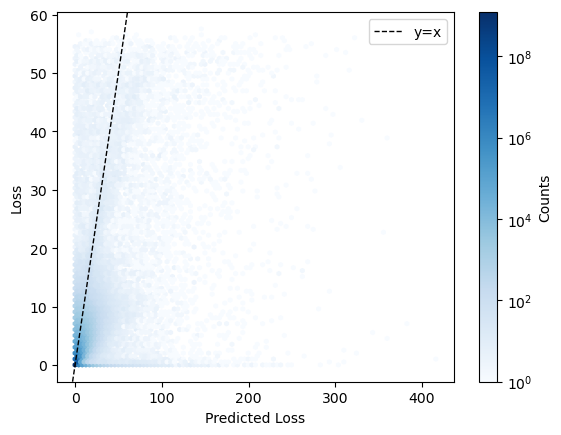

In [43]:
from matplotlib.colors import LogNorm
# plt.scatter(y_loss_agg, y_conf_agg);
# plt.hist2d(y_loss_agg, y_conf_agg, norm=LogNorm());
plt.hexbin(y_loss_agg, y_conf_agg, norm=LogNorm(), cmap='Blues');
plt.colorbar(label='Counts')
plt.axline((0,0), slope=1, ls='--', color='black', lw=1, label='y=x')
plt.xlabel('Predicted Loss')
plt.ylabel('Loss')
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
# plt.savefig('../../Figures/offline_loss_vs_predloss.png', dpi=300)
plt.show()

0.00071427436


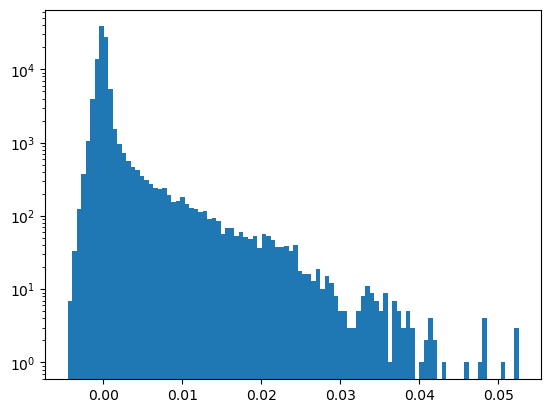

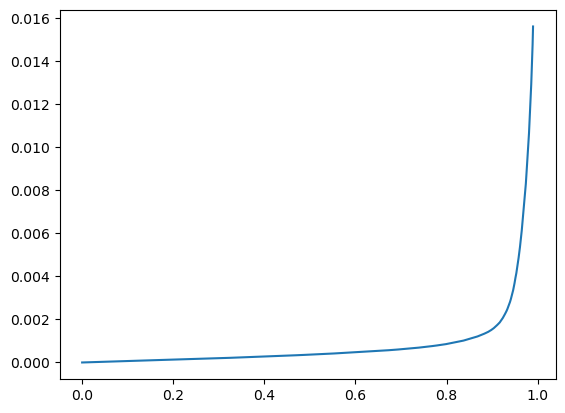

In [49]:
# plt.hist(np.abs(residuals), bins=100)
plt.hist(residuals, bins=100)
plt.yscale('log')
plt.figure()
sorted_tot_residual = np.sort(np.abs(residuals))
plot_quantiles = np.linspace(0,0.99,1000)
plot_idx_quantiles = (plot_quantiles*len(sorted_tot_residual)).astype(int)
plt.plot(plot_quantiles, sorted_tot_residual[plot_idx_quantiles])
print(sorted_tot_residual[int(len(sorted_tot_residual)*0.75)])

# plt.hist(tot_residual, bins=100, histtype='step', cumulative=True, density=True, ls='--', lw=2)

plt.show()

In [72]:
def reconstruct_dp_np(pmid, ps):
    phalf = np.empty((pmid.shape[0], pmid.shape[1]+1), dtype=pmid.dtype)
    phalf[:,-1] = ps
    for i in range(pmid.shape[1])[::-1]:
        phalf[:,i] = 2*pmid[:,i] - phalf[:,i+1]
    
    dp = phalf[:,1:] - phalf[:,:-1]
    
    return dp

In [73]:
pmids = (pmids * p_div[:-1]) + p_sub[:-1]
ps = (ps * p_div[-1]) + p_sub[-1]

dps = reconstruct_dp_np(pmids, ps)

y_preds /= out_scale
y_trues /= out_scale

In [74]:
grav = 9.80665 # m s-2
rho_h2o = 1e3 # kg m-3
alv   = 2.5008e6 #J/kg
als   = 2.8345e6 #J/kg
cpd   = 1004.64 # J K-1 kg-1

y_test_cons = y_preds

t_phy  = y_test_cons[:,0:60]
qv_phy = y_test_cons[:,60:120]
qc_phy = y_test_cons[:,120:180]
qi_phy = y_test_cons[:,180:240]
u_phy  = y_test_cons[:,240:300]
v_phy  = y_test_cons[:,300:360]
rain   = y_test_cons[:,360]
snow   = y_test_cons[:,361]

idx = np.s_[:,25:]

water_budget_residual = np.sum((qv_phy[idx] + qc_phy[idx] + qi_phy[idx]) * dps[idx] / grav, axis=1) + rain * rho_h2o + snow * rho_h2o
energy_budget_residual = np.sum((t_phy[idx] * cpd - qc_phy[idx]*alv - qi_phy[idx]*als) * dps[idx] / grav, axis=1) - \
                                rain * rho_h2o * alv - \
                                snow * rho_h2o * als
momentum_u_budget_residual = np.sum(u_phy[idx] * dps[idx] / grav, axis=1)
momentum_v_budget_residual = np.sum(v_phy[idx] * dps[idx] / grav, axis=1)

In [75]:
# dP_sum = np.sum(dP, axis=-1)[:,None]
# t_phy2 = t_phy - energy_budget_residual[:,None] / dP_sum * grav / cpd
# rain2 = rain - energy_budget_residual / rho_h2o / alv
# energy_budget_residual2 = np.sum((t_phy2 * cpd - qc_phy*alv - qi_phy*als) * dP / grav, axis=1) - \
#                                 rain * rho_h2o * alv - \
#                                 snow * rho_h2o * als
# # energy_budget_residual2 = np.sum((t_phy * cpd - qc_phy*alv - qi_phy*als) * dP / grav, axis=1) - \
# #                                 rain * rho_h2o * alv - \
# #                                 snow * rho_h2o * als - \
# #                                 energy_budget_residual

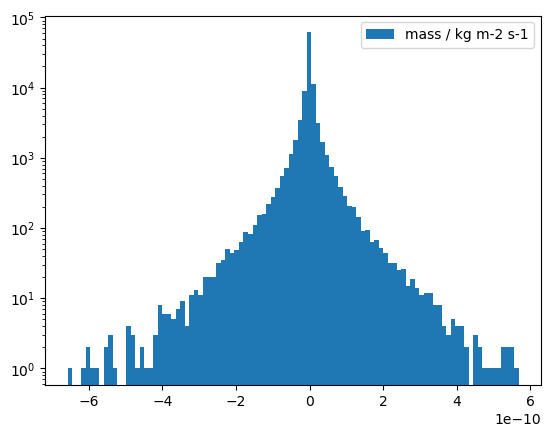

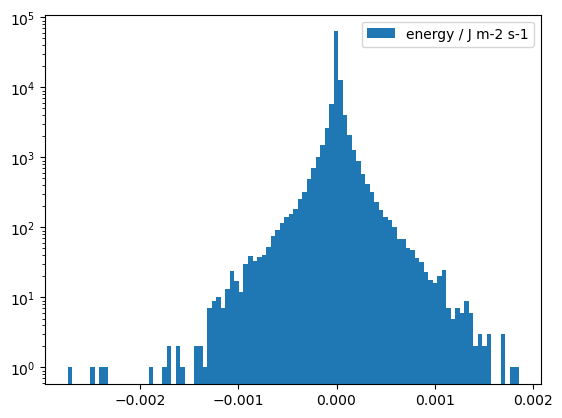

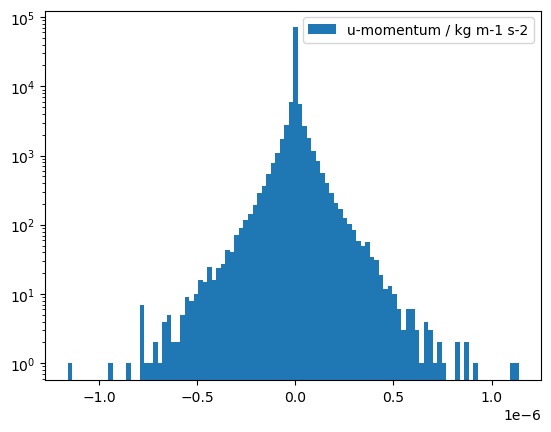

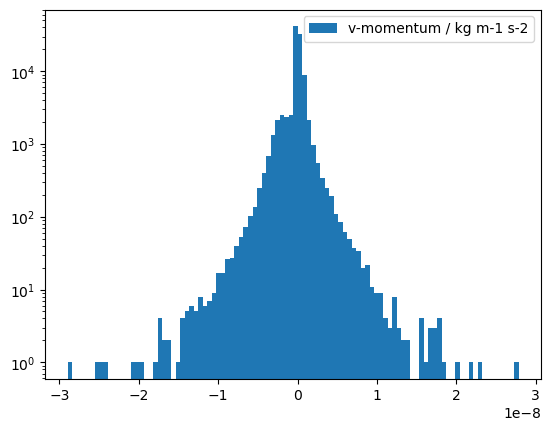

In [76]:
plt.figure()
plt.hist(water_budget_residual, bins=100, label='mass / kg m-2 s-1')
plt.yscale('log')
plt.legend()

plt.figure()
plt.hist(energy_budget_residual, bins=100, label='energy / J m-2 s-1')
plt.yscale('log')
plt.legend()
# plt.plot(energy_budget_residual2, 'o')
plt.figure()
plt.hist(momentum_u_budget_residual, bins=100, label='u-momentum / kg m-1 s-2')
plt.yscale('log')
plt.legend()
plt.figure()
plt.hist(momentum_v_budget_residual, bins=100, label='v-momentum / kg m-1 s-2')
plt.yscale('log')
plt.legend()

plt.show()

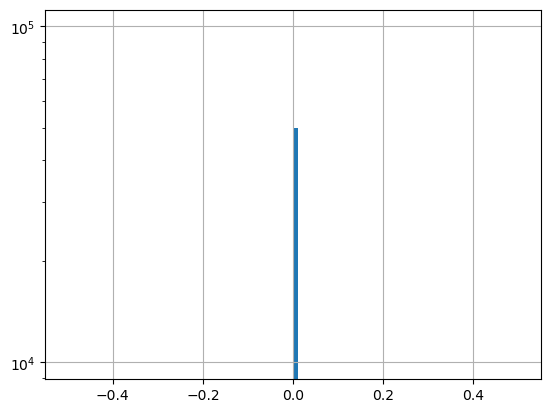

In [164]:
plt.hist(rain, bins=100);
plt.yscale('log')
plt.grid()

In [ ]:
np.savez(os.path.join(os.path.dirname(load_path), 'residuals.npz'),
         mass=water_budget_residual,
         energy=energy_budget_residual,
         u=momentum_u_budget_residual,
         v=momentum_v_budget_residual)

# End test conservative property

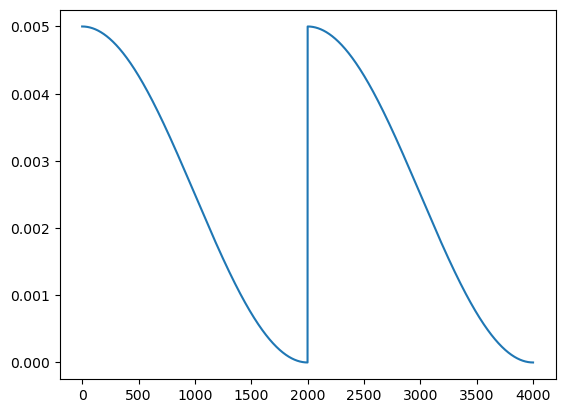

In [98]:
len(model.lrs)
plt.plot(model.lrs);

In [ ]:
!scancel 10579250

# Evaluate

In [22]:
# model = HighResLeapModel.load_from_checkpoint(checkpoint_path='/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/my_base_model_bestmodels_v5mlexpandcnv_1.2e6params/val_score=0.8249-best_model.ckpt',
model = HighResLeapModel.load_from_checkpoint(checkpoint_path='/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/my_base_model_bestmodels_v5mlexpandcnv_1.2e6params/val_score=0.8249-best_model.ckpt',
                                              input_size=params["input_dim"],
                                              output_size=params["output_dim"])

/work/bd1179/b309215/mambaforge/envs/py3.10_torch/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.3.3
/tmp/ipykernel_1029532/786681540.py:34: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.weight)
/tmp/ipykernel_1029532/786681540.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.bias)


In [30]:
load_path = '/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/training/hr_expandcnv_3.3M-2_wolatpres_nolargescalef_nosched_confrelu_train-loss-split_1gpu_2Msamples/val_score=0.7464-best_model.ckpt'

model = HighResLeapModel.load_from_checkpoint(checkpoint_path=load_path,
                                              # input_size=params["input_dim"],
                                              feature_target_lengths=feature_target_lengths,
                                              zeroout_index=zeroout_index,
                                              use_confidence=True,
                                              map_location=torch.device('cpu'))

/tmp/ipykernel_27097/573738443.py:70: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.weight)
/tmp/ipykernel_27097/573738443.py:71: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.bias)


In [32]:
model.to('cuda')

HighResLeapModel(
  (network): FFNN_LSTM_6_AVG(
    (LSTM_1): LSTM(150, 150, num_layers=4, batch_first=True, dropout=0.01, bidirectional=True)
    (Linear_1): Linear(in_features=29, out_features=150, bias=True)
    (Linear_2): Linear(in_features=1050, out_features=600, bias=True)
    (Linear_3): Linear(in_features=600, out_features=10, bias=True)
    (Linear_4_0): Linear(in_features=600, out_features=1200, bias=True)
    (Linear_4): Linear(in_features=1200, out_features=4, bias=True)
    (avg_pool_1): AvgPool1d(kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (criterion): HuberLoss()
  (mae_loss): L1Loss()
)

# Investigate high loss for one sample?

In [44]:
%%time
losses = []
model.eval()
for batch in tqdm(train_loader):
    x, y = batch
    x = x.to('cuda')
    y = y.to('cuda')
    for i in range(x.shape[0]):
        with torch.no_grad():
            y_pred = model(x[i][None,...])
            y_pred = y_pred[...,:302]
            loss = torch.mean(model.criterion(y_pred, y[i][None,...]))
        losses.append(loss.detach().cpu().numpy())

losses = np.concatenate(losses)
losses.shape

  0%|▎                                                                                                                                                                        | 4/2000 [00:17<2:13:14,  4.01s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x149045738540>
Traceback (most recent call last):
  File "/p/project/icon-a-ml/mambaforge/envs/heuer1_climlab/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/p/project/icon-a-ml/mambaforge/envs/heuer1_climlab/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/p/project/icon-a-ml/mambaforge/envs/heuer1_climlab/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/p/project/icon-a-ml/mambaforge/envs/heuer1_climlab/lib/python3.11/multiprocessing/po

KeyboardInterrupt: 

In [57]:
%%time
y_trues = []
y_preds = []
model.eval()
for batch in tqdm(val_loader):
    x, y = batch
    # print(x.size(), y.size())
    # y = y.view(y.size(1)*y.size(0), y.size(2))
    # x = x.view(x.size(1)*x.size(0), x.size(2), x.size(3))
    with torch.no_grad():
        y_pred = model(x)

    y_preds.append(y_pred.detach().cpu().numpy())
    y_trues.append(y.detach().cpu().numpy())
    
y_trues = np.concatenate(y_trues)
y_preds = np.concatenate(y_preds)
y_trues.shape, y_preds.shape
# Wall time: 24.9 s

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:28<00:00,  7.19it/s]


CPU times: user 25.5 s, sys: 174 ms, total: 25.6 s
Wall time: 28.7 s


((203040, 308), (203040, 308))

In [58]:
from sklearn.metrics import r2_score as sk_r2

r2vals = sk_r2(y_trues, y_preds, multioutput='raw_values')
r2score = np.mean(r2vals)

y_std = Y_STD.numpy()
y_mean = Y_MEAN.numpy()

y_trues = (y_trues * y_std) + y_mean
y_preds[:, y_std < (1.1 * ERR)] = 0
y_preds = (y_preds * y_std) + y_mean

r2vals_capped = sk_r2(y_trues, y_preds, multioutput='raw_values')
r2score_capped = np.mean(r2vals_capped)

# y_preds[:, ADJUSTMENT_MASK==0] = y[:, ADJUSTMENT_MASK==0]
# y_preds[:, MASK==0] = 0
# y_trues[:, MASK==0] = 0
y_preds[:, zeroout_index] = y_trues[:, zeroout_index]
y_preds[:, zeroout_index] = 0
y_trues[:, zeroout_index] = 0

r2score_masked = sk_r2(y_trues, y_preds)

r2score, r2score_capped, r2score_masked

(0.7726353901250259, 0.7726420410358735, 0.8181337986645204)

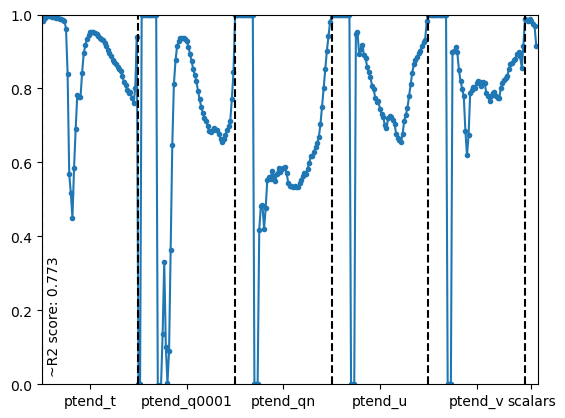

In [83]:
v5vec_outputs = ['ptend_t',
              'ptend_q0001',
              'ptend_qn',
              'ptend_u',
              'ptend_v',
]

v5scal_outputs = [
              'cam_out_NETSW',
              'cam_out_FLWDS',
              'cam_out_PRECSC',
              'cam_out_PRECC',
              'cam_out_SOLS',
              'cam_out_SOLL',
              'cam_out_SOLSD',
              'cam_out_SOLLD',
]

plt.plot(r2vals, 'o-', ms=3)
plt.ylim(0,1)
plt.xlim(0,len(v5vec_outputs)*NLEV+len(v5scal_outputs))

for i in range(len(v5vec_outputs)+1):
    plt.axvline(i*NLEV, ls='--', c='black')


plt.xticks([NLEV*i+30 for i in range(len(v5vec_outputs))] + [NLEV*len(v5vec_outputs)+4], v5vec_outputs+['scalars'])
plt.text(0.01, 0.03, f'~R2 score: {r2score:.3f}', transform=plt.gca().transAxes, rotation='vertical')
# for i,out in enumerate(v5scal_outputs):
#     plt.axvline(len(v5vec_outputs)*NLEV+i, ls='--')
plt.savefig(f'../../Figures/offline_r2_v5expandcnv_team5reduced.jpg', bbox_inches="tight")

plt.show()

In [64]:
f'R2 score: {r2score:.3f}'

'R2 score: 0.77'

In [63]:
r2_score

<function __main__.r2_score(y_pred, y_true)>

# Loss testing

In [24]:
def get_my_loss(reduction='mean'):
    def my_loss(output, target):
        absdiff = torch.abs(output - target)
        loss = torch.where(absdiff < 1, absdiff**2, absdiff)
        if reduction == 'mean':
            loss = torch.mean(loss)
        return loss
    return my_loss

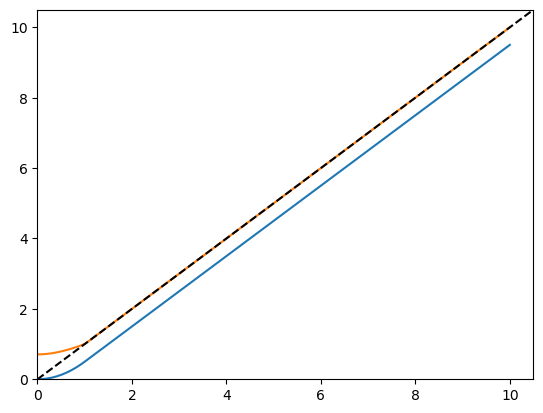

In [37]:
test_loss = nn.HuberLoss(delta=1, reduction='none')
# test_loss = get_my_loss(reduction='none')

x1test = torch.linspace(0,10,100)[None,:].reshape(1,-1)
x2test = torch.zeros_like(x1test)

ytest = test_loss(x1test, x2test)

plt.plot(x1test.squeeze(), ytest.squeeze())
ytest2 = torch.where(x1test<1, torch.sqrt(ytest+0.), ytest+0.5)
plt.plot(x1test.squeeze(), ytest2.squeeze())
plt.axline([0,0], slope=1, ls='--', color='black')
plt.xlim(0,None)
plt.ylim(0,None)
plt.show()